In [3]:
from segment_lidar import samlidar, view
import pylas
import open3d as o3d
import numpy as np
import laspy
import cv2
import matplotlib.pyplot as plt

## First we define function to convert files 

PCD -> LAS
LAS -> PCD

In [4]:
def convert_pcd_to_las(pcd_file=None, point_cloud=None, las_file="downsampled.las"):
    if(pcd_file is None and point_cloud is None):
        print("No input file")
        return
    # Read the PCD file
    if point_cloud is None:
        pcd = o3d.io.read_point_cloud(pcd_file)
    else:
        pcd = point_cloud
    
    # Extract points and colors from the PCD file
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    
    r = colors[:, 0]
    g = colors[:, 1]
    b = colors[:, 2]
    
    # Create a LAS file with RGB fields
    las = pylas.create(point_format_id=3)
    las.x = points[:, 0]
    las.y = points[:, 1]
    las.z = points[:, 2]
    las.red = r
    las.green = g
    las.blue = b
    
    # Write the LAS file
    las.write(las_file)
    return las_file
    
def convert_las_to_pcd(las) -> o3d.t.geometry.PointCloud:
    # get points
    points = np.vstack((las.x, las.y, las.z)).transpose()
    print("point len : ",  len(points))

    # make blank cloud
    pcd = o3d.geometry.PointCloud()

    # add x,y,z to o3d cloud
    pcd.points = o3d.utility.Vector3dVector(points)

    # if rgb present, convert to o3d colors
    all_dims = list(las.point_format.dimension_names)[3:]
    
    if "red" in all_dims and "green" in all_dims and "blue" in all_dims:
        colors = np.vstack((las.red, las.green, las.blue)).transpose()
        pcd.colors = o3d.utility.Vector3dVector(colors)
        all_dims.remove("blue")
        all_dims.remove("green")
        all_dims.remove("red")
    return pcd


## Voxel function for downsampling PCD files


If your pointcloud file is expressed in meters, voxel_size=0.05 will mean the voxel grid will be made up of voxels measuring 5 x 5 x 5 cm. 
    
After filtering the pointcloud density is reduced so that you have only one point per such voxel, so, one point per 5 centimeter square.
    

In [5]:
def voxel_downsample(pcd, voxelvalue = 1): # Increase voxel size to reduce memory usage
    downsample = pcd.voxel_down_sample(voxelvalue)
    print("before : ", pcd, ", after : ", downsample)
    return downsample, len(downsample.points)

## Run the Lidar segment algo

We use the sam_vit_h_4b8939.pth model which is the smaller model.

In [6]:
#Obviously this function could take a while....
def compute_segment_lidar(input_file, save_path, labeled_tif_path, raster_tif_path):
    viewpoint = view.TopView()

    model = samlidar.SamLidar(ckpt_path="sam_vit_h_4b8939.pth")
    points = model.read(input_file)
    labels, *_ = model.segment(points=points, view=viewpoint, labels_path=labeled_tif_path, image_path=raster_tif_path)
    model.write(points=points, segment_ids=labels, save_path=save_path)
    return save_path, labeled_tif_path
    

## Benchmark functions

This function show use cv2 to find contour of a image, with a treshold.

We use it on the segment-lidar's segmentID generated image. It's easier and more accurate to find contour. In Cloudcompare the labeled image look like this : 

<img src="./image/labeled.png"/>

In [7]:
# base on the labeled image generate by lidar-segment

def benchmark(labeled_tif_path, nb_contour_list):
    image = cv2.imread(labeled_tif_path)
    # convert the image to grayscale format
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # apply binary thresholding
    ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)
    
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    
    nb_contours = len(contours)
    nb_contour_list.append(nb_contours)
    return nb_contour_list, contours


cv2 threshold method : 

<img src="./image/cv2_thresh.png" />

cv2 contours detection : 

<img src="./image/cv2_contours.png" />

We will apply this contour son the real image later to extract building, tree...

# Main loop

Loop arrangement : 

- Start with a .las file
<ul>
    <li>Convert to pcd</li>
    <li>Downsamp the file</li>
    <li>Convert to las</li>
    <li>Run Lidar-segment model</li>
    <li>Compute test benchmark of the labeled/rester images</li>
</ul>

Iteration number :  0
point len :  29378196
Reading downsampled.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 10.24 seconds. The point cloud contains 29378196 points.

/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/labeled.tif  now OK
- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 253.16 seconds. Number of instances: 216

Writing the segmented point cloud to downsample_computed.las...
Writing is completed in 23.59 seconds.



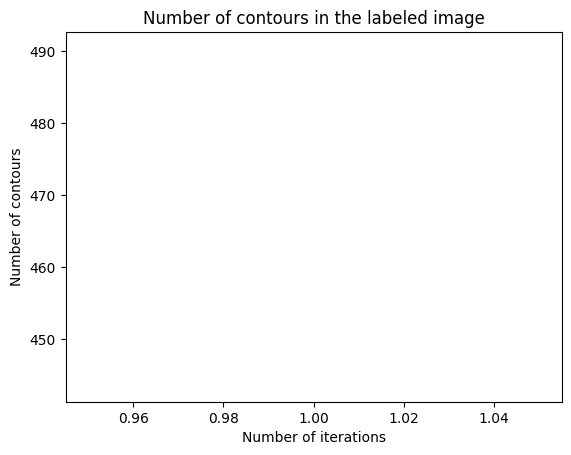

[29378196]
1
[0]


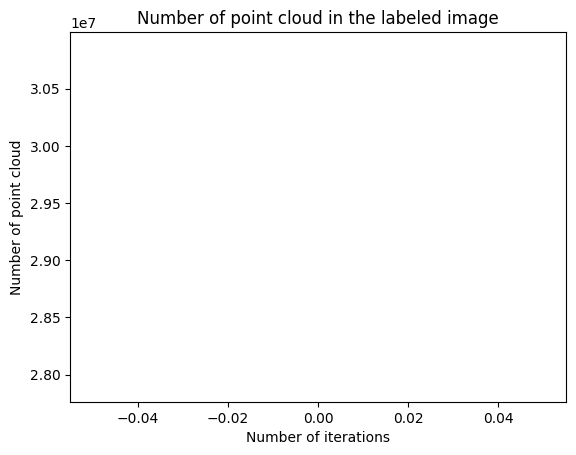

In [ ]:
las = laspy.read("../../../scan_PUT/block_3.las")
nb_iteration = 1
voxel_size = 0.12

label_path = "/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/labeled.tif"
raster_path ="/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/raster.tif"

las_downsample = "downsampled.las"
las_downsample_computed = "downsample_computed.las"

nb_contour_list = list()
nb_pointcloud = list()
contours = list()

for i in range(nb_iteration):
    print("Iteration number : ", i)
    if(i == 0):
        pcd_before = convert_las_to_pcd(las)
        pcd_downsample, nb_pointcloud_after = pcd_before, len(pcd_before.points)
    else:
        las = laspy.read(las_downsample)
        pcd_before = convert_las_to_pcd(las)
        voxel_size = voxel_size * 2
        pcd_downsample, nb_pointcloud_after = voxel_downsample(pcd_before, voxel_size)
    
    nb_pointcloud.append(nb_pointcloud_after)

    las_downsample = convert_pcd_to_las(point_cloud=pcd_downsample, las_file=las_downsample)

    #This line take a while...
    compute_segment_lidar(las_downsample, las_downsample_computed, label_path, raster_path)

    # Run benchmark
    nb_contour_list, contour = benchmark(label_path, nb_contour_list)
    contours.append(contour)
    
xs = [x+1 for x in range(len(nb_contour_list))]
plt.plot(xs, nb_contour_list)
plt.xlabel("Number of iterations")
plt.ylabel("Number of contours")
plt.title("Number of contours in the labeled image")
plt.show()

print(nb_pointcloud)
print(len(nb_pointcloud))
xs = [x for x in range(len(nb_pointcloud))]
print(xs)
plt.plot(xs, nb_pointcloud)
plt.xlabel("Number of iterations")
plt.ylabel("Number of point cloud")
plt.title("Number of point cloud in the labeled image")
plt.show()

# The main loop take a while ! Reduce the time by reducing the number of iterations.

# My config : Rizen5-5000, 1 iteration = 6 minutes 


## Save each contour as a file 

In [9]:
# Just need few processing before....
final_contours = list()
print(len(contours))
for contour in contours:
    print(len(contour))
    for cont in contour:
       final_contours.append(cont)

1
467


Nombre de contours trouvés: 467


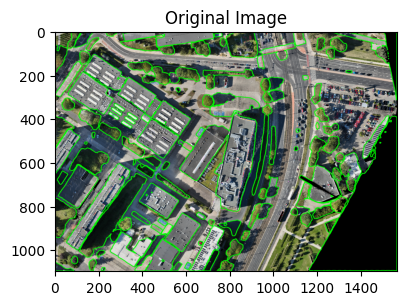

In [ ]:
import os

if not os.path.exists('../data'):
    os.makedirs('../data')
image = cv2.imread(raster_path)

if image is None:
    print("Erreur: l'image n'a pas pu être chargée.")
else:    
    print(f"Nombre de contours trouvés: {len(final_contours)}")
    
    # Parcourir chaque contour et enregistrer les sous-images
    # For each contours we save them in data folder (CNN processing)
    for i, contour in enumerate(contours):
        if not os.path.exists(f'../data/{i}'):
            os.makedirs(f'../data/{i}')
        for j, cont in enumerate(contour):
            x, y, w, h = cv2.boundingRect(cont)
            roi = image[y:y+h, x:x+w]

            # Vérifiez que la région d'intérêt n'est pas vide
            # Check if the size is not empty
            if roi.size > 0:
                cv2.imwrite(f'../data/{i}/contour_{j}.png', roi)
    
    # draw contours on the original image
    image_copy = image.copy()
    cv2.drawContours(image=image_copy, contours=final_contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    # Visualize the masks and contours
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.show()

Were we have the image with cv2 contours apply

## Use the CNN model to see how many classes there are

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

PATH = "../cnn/modelcnn.pth"
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        """
        Parameters:
            in_channels: int
                The number of channels in the input image
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1\n",


        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1) 
        # Max pooling layer: 2x2 window, stri   
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, paddi 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1) 
        self.fc1 = nn.Linear(4096, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x) 
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation\n",
                  # Apply max pooling\n",
  
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor\n",
        
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)
        # Taille de sortie : (len_dataloader, 2)\n",
        return x

model = CNN()
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=2, bias=True)
)

## Run the model

In [12]:
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Toutes les images seront en 64x64
    transforms.ToTensor(),  # Convertit en [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation [-1,1]
])


def evaluate(cnn):
    total = 0
    labels = [[] for _ in range(len(os.listdir("../data")))]
    data_folder = "../data"
    for i, folders in enumerate(os.listdir(data_folder)):
        for j, filename in enumerate(os.listdir(os.path.join(data_folder, folders))):
            data_file = os.path.join(data_folder, folders, filename)
            total = total +1
            #print(plt.imread(data_file).shape[0], plt.imread(data_file).shape[1])
            if(plt.imread(data_file).shape[0] < 64):
                continue   
            if(plt.imread(data_file).shape[1] < 64):
                continue
            # Load the image
            image = Image.open(data_file).convert("RGB")
            # Apply the same transformations used during training
            transform = transforms.Compose([
                transforms.Resize((64, 64)),  # Resize to 64x64
                transforms.ToTensor(),  # Convert to tensor
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
            ])
            image = transform(image).unsqueeze(0)  # Add batch dimension
    
            cnn.eval()  
    
            with torch.no_grad():
                output = cnn(image)
                _, predicted = torch.max(output, 1)
    
            # Map the predicted class index to the class label
            label_map = {0: "building", 1: "leaves"}
            predicted_label = label_map[predicted.item()]
            labels[i].append(predicted_label)

    return labels, total

labels, total = evaluate(model)
print(labels)

[['leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves'], ['leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'building', 'leaves', 'leaves', 'building', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'building', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves'], ['leaves']]


## Analys

[['leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves'], ['leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'building', 'leaves', 'leaves', 'building', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'building', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves', 'leaves'], ['leaves']]


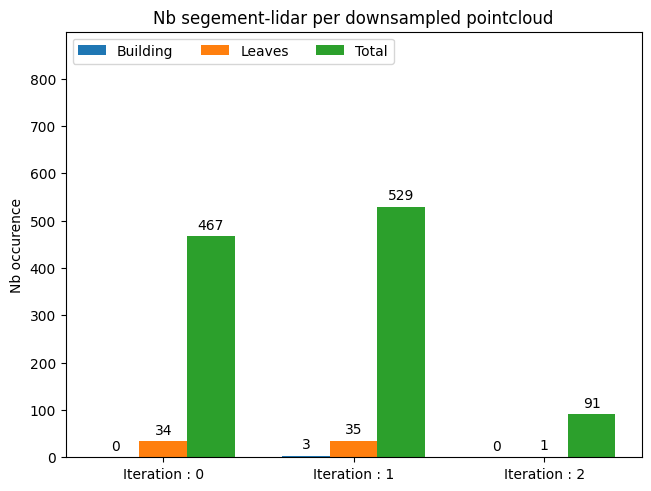

In [13]:
import matplotlib.pyplot as plt
import numpy as np


test_contours = [['building', 'leaves', 'building', 'building'], ['building', 'leaves', 'building', 'building'], ['building', 'leaves', 'building', 'building'], ['building', 'leaves', 'building', 'building'], ['building', 'leaves', 'building', 'building']]

#contours = test_contours
contours = labels
len_contours = len(contours)
print(contours)
species = list()
for i in range(len_contours):
    species.append("Iteration : "+str(i))
informations = {
    'Building': [0] * len_contours,
    'Leaves': [0] * len_contours,
    'Total': [0] * len_contours,
}

for i in range(len(contours)):
    for j in range(len(contours[i])):
        if(contours[i][j] == "building"):
            informations['Building'][i] = informations['Building'][i] + 1
        else:
            informations['Leaves'][i] = informations['Leaves'][i] +1
           
data_folder = "../data"
for i, folders in enumerate(sorted(os.listdir(data_folder))):
        for j, filename in enumerate(sorted(os.listdir(os.path.join(data_folder, folders)))): 
                informations['Total'][i] = informations['Total'][i] + 1

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in informations.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nb occurence')
ax.set_title('Nb segement-lidar per downsampled pointcloud')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, max(informations['Total'])*1.7)

plt.show()

We only predict classes of images when the size is > to 64